# Load fundamental modules & initialize variables

In [1]:
# Standard library imports
from collections import OrderedDict as od
from glob import glob
from importlib import reload
import inspect
import itertools
import os
import os.path as op
import random
import sys
from time import time
import warnings

# Third party imports
import h5py
import matplotlib as mpl # plotting
from matplotlib.lines import Line2D # plotting
import matplotlib.patches as patches # plotting
import matplotlib.pyplot as plt # plotting
import matplotlib.gridspec as gridspec  # plotting
import numpy as np # functions to analyze and manipulate arrays & matrices
import pandas as pd # dataframes
import scipy.interpolate as interp # scientific computation 
import scipy.io as sio # scientific computation 
import scipy.stats as stats # scientific computation 
import scipy.ndimage as ndi
import seaborn as sns # plotting
from sklearn.decomposition import PCA # tools for machine learning and statistical modeling. Useful for predictions of unobserved values.
import statsmodels.api as sm # tools for statistical analysis. Useful for statistical inference and statistical hypothesis testing.
from statsmodels.formula.api import ols

# Local application imports
sys.path.append('/home1/cjmac/code/general')
sys.path.append('/home1/cjmac/code/manning_replication')
sys.path.append('/home1/cjmac/code/projects/')
import array_operations as aop # for coding
import data_io as dio # for coding
from eeg_plotting import plot_trace, plot_trace2 #plotting
from time_cells import spike_sorting, spike_preproc, events_preproc, events_proc, time_bin_analysis, trial_phase_analysis # processing eeg data

# Initializing commands
%matplotlib inline
warnings.filterwarnings( 'ignore' )
pd.options.display.max_rows = 500
pd.options.display.max_columns = 999

# Plotting parameters
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15 
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 19
mpl.rcParams['figure.figsize'] = (6.85039, 4.79527) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42
# warnings.filterwarnings( 'default' )

# Plotting colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)
# Plotting font
font = {'tick': 12,
        'label': 14,
        'fig': 16}

In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases

In [2]:
def get_df_subset(df,
                  columns,
                  rows =  None,
                  unnest = None
                 ):
    """Obtain a subset of a pandas dataframe. Index will be reset for the new data frame.

    Parameters
    ----------
    df = pd.DataFrame
    columns = string, column number, list of column numbers, list of stings
    rows = Accepts a dictionary of key (column name) : value
    unnest = Accepts a list of string or integers. The type MUST be the same as used for columns. Can only unnest one level.

    Returns
    ----------
    df = pd.DataFrame
    """
    # process the columns argument
    # the section below ensures that the argument columns is a string, integer, list of strings, or list of integers
    if isinstance(columns, str):
        columns = [columns]       
    elif isinstance(columns, int):
        columns = [columns]
    elif isinstance(columns, list) & all(isinstance(item, str) for item in columns): #list of strings
        pass
    elif isinstance(columns, list) & all(isinstance(item, int) for item in columns): #list of integers
        pass
    elif (isinstance(columns, float)): # a single floating point number
        _columns = int(columns)
        _diff = _columns - columns  
        if abs(_diff) > 0:
            raise ValueError('You provided a floating point column number that does not pass as an integer.')
        else:
            columns = list(_columns)
    elif isinstance(columns, list) & any(isinstance(item, float) for item in columns): #if a list that contains no strings has float types, need to confirm that they are passable as integers
        _anyfloat = any([(abs(int(item) - item))>0 for item in columns if isinstance(item, float)])
        if _anyfloat:
            raise ValueError('You provided a floating point column number that does not pass as an integer.')
        else:
            columns =  [int(item) if isinstance(item, float) else item for item in columns]
    
    # process the rows argument
    # the section below ensures that the argument columns is a string, integer, list of strings, or list of integers
    if rows == None:
        pass
    else:
        if not isinstance(rows, dict):
            raise ValueError('The rows argument must be a dictionary to flag the rows you want.')
        else: 
            query = ' and '.join([f'{k} == {repr(v)}' for k, v in rows.items()]) 
            df = df.query(query).reset_index(drop=True)
           
    flag_column_str = True 
    if all(isinstance(item, str) for item in columns):
        if not all([(isinstance(item, str) & (item in df.columns)) for item in columns]):
            raise ValueError('At least one of the str elements in the columns argument is not a column name in the dataframe.')
    else:
        flag_column_str = False
        if any([((item > len(df.columns)) | (item < 0)) for item in columns]):
            raise ValueError('At least one of the integer elements in the columns argument is outside the number of columns in the dataframe.')
    
    # extract subset from df
    if flag_column_str:
        df = df[columns]
    else:
        df = df.iloc[:, columns]

    # process the unnest argument
    if unnest != None:
        _new_col_num = [_new_col for _new_col, _ in enumerate(columns)]
        _col_mapping = dict(zip(columns, _new_col_num))
        for item in unnest:    
            if isinstance(item, str):
                _df = pd.DataFrame(df[item].tolist())
                _col_loc = df.columns.get_loc(item)
                _new_col_names = [f"{item}{num}" for num in [*range(0, len(_df.columns), 1)]]
                _df.columns =_new_col_names
                [df.insert(_col_loc + col+1, _new_col_names[col], _df[_new_col_names[col]]) for col, _ in enumerate(_new_col_names)]
                df.drop(columns=item, inplace=True)
            elif isinstance(item, int):
                _df = pd.DataFrame(df.iloc[:, _col_mapping[item]].tolist())
                _new_col_names = [f"{item}_{num}" for num in [*range(0, len(_df.columns), 1)]]
                _new_col_names.reverse()
                [df.insert(_col_mapping[item] + 1, _new_col_names[col], _df[col]) for col, _ in enumerate(_new_col_names)]
                df.drop(df.columns[_col_mapping[item]], inplace=True, axis=1)
                _keys = list(_col_mapping.keys())
                _keys = _keys[_keys.index(item)+1:]
                _new_mapping = {item:_col_mapping[item] + len(_new_col_names) - 1 for item in _keys}
                _col_mapping.update(_new_mapping)

    return df

def get_spikes_xy_df (spikes,
                      set_interp,
                      categorical_object,
                     ):
    
    spikes_xy = pd.DataFrame(set_interp(spikes.spike_times[spikes.chan[spikes.chan == int(which_cell.split('-')[0])].index[int(which_cell.split('-')[1])-1]][categorical_object.codes>=0]),
                             columns=['trial', 'time', 'x', 'y', 'hd', 'moving']
                            )
    spikes_xy = spikes_xy.dropna(axis=0).reset_index(drop=True)
    spikes_xy['trial'] = spikes_xy.trial.astype(int)
    spikes_xy['moving'] = spikes_xy.moving.astype(int)
    return spikes_xy

## Define project directory and subject session; Load Events and Spikes

In [3]:
# what is the top level folder under which the events class are stored for each experimental session
proj_dir ='/home1/cjmac/projects/time_cells'

# which experimental session are we dealing with
subj_sess = 'U554_ses0'

#identify all exprimental sessions with an events class
sessions = np.unique([op.basename(f).split('-')[0] 
                      for f in glob(op.join(proj_dir, 'analysis', 'events', '*-Events.pkl'))])

#load the events class
events = events_proc.load_events(subj_sess, proj_dir=proj_dir)

# create a data frame containing info about each neuron in subj_sess and their spike times
spikes = spike_preproc.format_spikes(subj_sess,
                                     conv_factor='infer',
                                     add_montage_info=False,
                                     fr_thresh=0.1,
                                     overwrite=False,
                                     save_output=False,
                                     split_files=True,
                                     verbose=True
                                    )

Loading saved Events file
The first timestamp in lfp_timestamps before zero-ing & before conv factor is 1654709925.092
The first timestamp in lfp_timestamps before zero-ing & after conv factor is 1654709925091.791
The first timestamp in lfp_timestamps after zero-ing & conv factor is 0.000
Conversion factor is 1000.0
153210591 timestamps over 79 min and 47.8 s
Sampling rate is 32000 Hz
Found 80 wave_clus files.

Found 28 neurons
Firing rates:
count    28.000000
mean      0.825314
std       1.083380
min       0.105476
25%       0.210847
50%       0.391514
75%       0.939413
max       4.795702
Name: fr, dtype: float64



KeyError: 'hemroi'

In [7]:
events.events.to_csv('./outputs/csv/events_all_U554.csv')

## Spatial trajectory plots with spikes overlayed

NameError: name 'spikes' is not defined

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


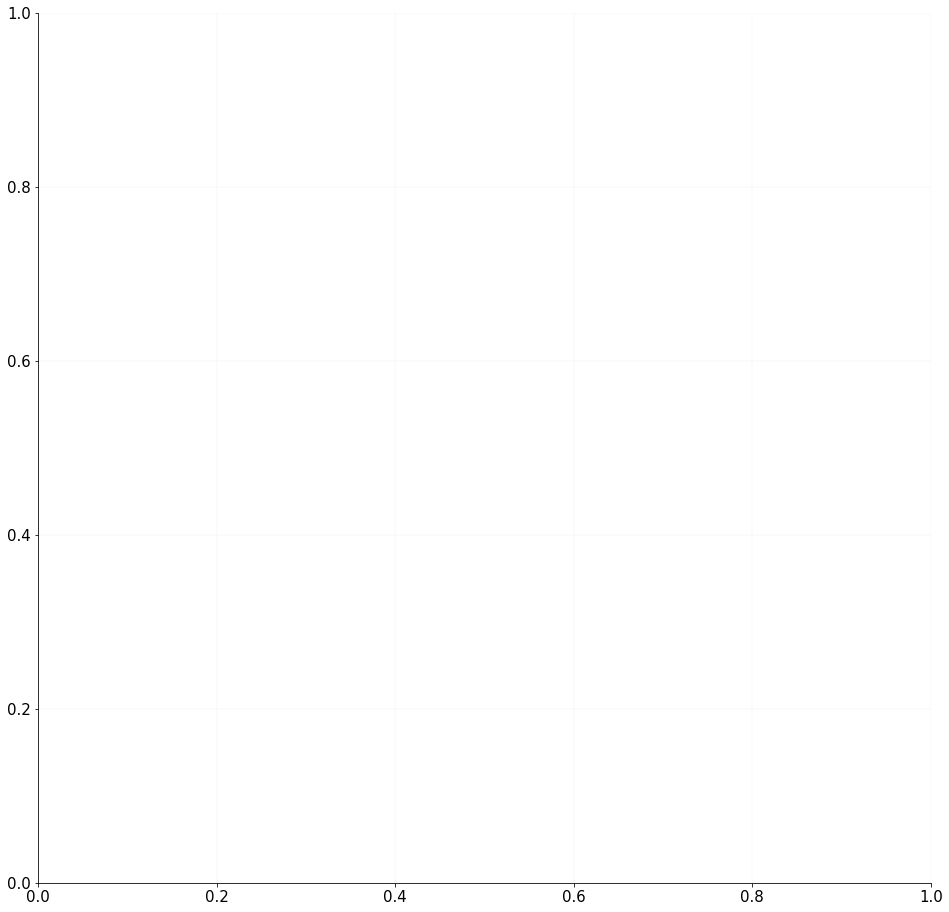

In [4]:
which_cell = '13-1'
which_trials = random.sample(range(1, 37), 16)
which_trials.sort()

# set number of columns (use 3 to demonstrate the change)
ncols = 4
# calculate number of rows
nrows = 4 #len(which_trials) // ncols + (len(which_trials) % ncols > 0)
# fewf
gameState = ['Retrieval']

for ind, which_gameState in enumerate(gameState):
    
    fig, ax = plt.subplots(figsize=[16, 16], sharex = 'col', sharey = 'row')
    
    # obtain a subset of the events.positions dataframe representing the S's spatial trajectories & other behavioral variables
    columns = ['trial', 'pos', 'rotation', 'moved_pos', 'start_time', 'stop_time', 'gameState']
    unnest = ['pos']
    xy = get_df_subset(events.positions.copy(), columns, rows = {'gameState':which_gameState}, unnest = unnest)
    xy.rename(columns={'pos0':'x', 'pos1':'y', 'moved_pos':'moving', 'rotation':'hd'}, inplace=True)
    xy.insert(7, 'time',xy[['start_time', 'stop_time']].median(axis=1).astype('int'))
    xy.drop(labels=['start_time', 'stop_time'], inplace=True, axis=1)
    
    # create an interpololater 
    set_interp = interp.interp1d(xy.time.squeeze(),
                                 xy[['trial', 'time', 'x', 'y', 'hd', 'moving']],
                                 axis=0, 
                                 kind='nearest',
                                 bounds_error=False,
                                 assume_sorted=True
                                )
    
    bins = pd.IntervalIndex.from_arrays(np.array(events.event_times.loc[events.event_times.gameState == which_gameState].time.tolist())[:,0],
                                np.array(events.event_times.loc[events.event_times.gameState == which_gameState].time.tolist())[:,1]
                               )

    categorical_object = pd.cut(spikes.spike_times[spikes.chan[spikes.chan == int(which_cell.split('-')[0])].index[int(which_cell.split('-')[1])-1]], #converts the cell identifier into a number ranging from 1 - total number of cells in session
                                bins, 
                                retbins=False
                               )
    
    spikes_xy = get_spikes_xy_df(spikes, set_interp, categorical_object)

    # loop through the length of tickers and keep track of index
    for n, trial in enumerate(which_trials):
        # add a new subplot iteratively using nrows and cols
        ax = plt.subplot(nrows, ncols, n + 1)
        ax.set_title(f'trial {trial:02}', fontdict={'fontsize':14})
        ax.set_xlim(-.5, 30.5)
        ax.set_ylim(-.5, 30.5)

        #add rectangle to plot
        patch_collection = []
        for rect_coord in events.maze.maze.coords.loc[events.maze.maze.region!='wall']:
            patch_collection.append(patches.Rectangle(rect_coord[0], 
                                                      rect_coord[1][0]-rect_coord[0][0],
                                                      rect_coord[1][1]-rect_coord[0][1],
                                                      facecolor=(0.875,0.875,0.875,),
                                                     )
                                   )

        ax.add_collection(mpl.collections.PatchCollection(patch_collection, match_original=True, edgecolor=(0.875,0.875,0.875,)))

        x = np.array(xy.loc[xy.trial==trial].x.reset_index(drop=True))
        y = np.array(xy.loc[xy.trial==trial].y.reset_index(drop=True))

        dx = x[1:]-x[:-1]
        dy = y[1:]-y[:-1]
        step_size = np.sqrt(dx**2+dy**2)
        dydx = np.concatenate(([0], np.cumsum(step_size)))

        # Create a set of line segments so that we can color them individually
        # This creates the points as a N x 1 x 2 array so that we can stack points
        # together easily to get the segments. The segments array for line collection
        # needs to be (numlines) x (points per line) x 2 (for x and y)
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        # Create a continuous norm to map from data points to colors
        norm = plt.Normalize(dydx.min(), dydx.max())
        lc = mpl.collections.LineCollection(segments, cmap='cool', norm=norm)
        # Set the values used for colormapping
        lc.set_array(dydx)
        lc.set_linewidth(5)
        line = ax.add_collection(lc)

        # add the start and end of the trajectory
        marker_style = dict(color='cyan', marker='o', markersize=15)    
        ax.plot(x[0], y[0], **marker_style)
        marker_style = dict(color='magenta', marker='o', markersize=15)
        ax.plot(x[-1], y[-1], **marker_style)

        # add spikes
        marker_style = dict(color='black', marker='o', markersize=5)  
        ax.plot(spikes_xy.loc[spikes_xy['trial']==trial].x,
                spikes_xy.loc[spikes_xy['trial']==trial].y,
                linestyle = 'None',
                **marker_style
               )

        # add gems
        marker_style = dict(color='green', marker='*', markersize=15)  
        ax.plot(events.gold_spawned.loc[events.gold_spawned['trial']==trial].gold_x,
                events.gold_spawned.loc[events.gold_spawned['trial']==trial].gold_z,            linestyle = 'None',
                **marker_style
               )
        
fig.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.savefig(f"SpatialCoding_SingleTrials_{which_gameState}_{which_cell}.pdf", dpi=300)
plt.show()  

In [ ]:
spikes_xy

## Create trial averaged spatial firing rate heat plot for Encoding Period

In [ ]:
xedges = np.linspace(0, 31, 30)
yedges = np.linspace(0, 31, 30)

xy_counts, xedges, yedges = np.histogram2d(xy.x, xy.y, bins=(xedges, yedges))
xy_counts = xy_counts.T

sigma_x=2
sigma_y=2
sigma = [sigma_y, sigma_x]
xy_counts_smooth = ndi.filters.gaussian_filter(xy_counts, sigma, mode='constant')
xy_counts_smooth[xy_counts==0]=np.nan

# fig, ax = plt.subplots(figsize=[5, 5])
# ax.imshow(xy_counts_smooth, interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

spikes_xy_counts, xedges, yedges = np.histogram2d(spikes_xy.x, spikes_xy.y, bins=(xedges, yedges))
spikes_xy_counts = spikes_xy_counts.T

sigma_x=2
sigma_y=2
sigma = [sigma_y, sigma_x]
spikes_xy_counts_smooth = ndi.filters.gaussian_filter(spikes_xy_counts, sigma, mode='constant')

# fig, ax = plt.subplots(figsize=[5, 5])
# ax.imshow(spikes_xy_counts, interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

spikes_xy_rates = np.divide(spikes_xy_counts, (xy_counts*0.025))
spikes_xy_rates = np.nan_to_num(spikes_xy_rates)

sigma_x=2
sigma_y=2
sigma = [sigma_y, sigma_x]
spikes_xy_rates_smooth = ndi.filters.gaussian_filter(spikes_xy_rates, sigma, mode='constant')
spikes_xy_rates_smooth[xy_counts==0]=np.nan

fig, ax = plt.subplots(figsize=[5, 5])

for rect_coord in events.maze.maze.coords.loc[events.maze.maze.region!='wall']:
        patch_collection.append(patches.Rectangle(rect_coord[0], 
                                                  rect_coord[1][0]-rect_coord[0][0],
                                                  rect_coord[1][1]-rect_coord[0][1],
                                                  facecolor=(0.875,0.875,0.875)
                                                 )
                               )
        
ax.add_collection(mpl.collections.PatchCollection(patch_collection, match_original=True, edgecolor=(0.875, 0.875, 0.875,)))

im = ax.imshow(spikes_xy_rates_smooth, interpolation='nearest', origin='lower', cmap='jet',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin=0, vmax=3, zorder=1)

cb = fig.colorbar(im, ax=ax, shrink=0.8)
cb.set_ticks([0, 1.5, 3])
cb.set_label('spikes/s')

plt.savefig(f"SpatialCoding_TrialAverage_Encoding_{which_cell}.pdf", dpi=300)
plt.show()

## Create trial averaged spatial firing rate heat plot for Retreival Period

In [ ]:
# bins = pd.IntervalIndex.from_arrays(np.array(events.event_times.loc[events.event_times.gameState == 'Retrieval'].time.tolist())[:,0],
#                                     np.array(events.event_times.loc[events.event_times.gameState == 'Retrieval'].time.tolist())[:,1]
#                                    )

# categorical_object = pd.cut(spikes.spike_times[spikes.chan[spikes.chan == int(which_cell.split('-')[0])].index[int(which_cell.split('-')[1])-1]], bins, retbins=False)


# spikes_xy = get_spikes_xy_df(spikes, set_interp, categorical_object)

# spikes_xy = pd.DataFrame(set_interp(spikes.spike_times[spikes.chan[spikes.chan == int(which_cell.split('-')[0])].index[int(which_cell.split('-')[1])-1]][categorical_object.codes>=0]),
#                          columns=['trial', 'time', 'x', 'y', 'hd', 'moving']
#                         )

# spikes_xy = spikes_xy.dropna(axis=0).reset_index(drop=True)

spikes_xy['trial'] = spikes_xy.trial.astype(np.int64)
spikes_xy['moving'] = spikes_xy.moving.astype(np.int64)

xedges = np.linspace(0, 31, 30)
yedges = np.linspace(0, 31, 30)

xy_counts, xedges, yedges = np.histogram2d(xy.x, xy.y, bins=(xedges, yedges))
xy_counts = xy_counts.T

sigma_x=2
sigma_y=2
sigma = [sigma_y, sigma_x]
xy_counts_smooth = ndi.filters.gaussian_filter(xy_counts, sigma, mode='constant')
xy_counts_smooth[xy_counts==0]=np.nan

# fig, ax = plt.subplots(figsize=[5, 5])
# ax.imshow(xy_counts_smooth, interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

spikes_xy_counts, xedges, yedges = np.histogram2d(spikes_xy.x, spikes_xy.y, bins=(xedges, yedges))
spikes_xy_counts = spikes_xy_counts.T

sigma_x=2
sigma_y=2
sigma = [sigma_y, sigma_x]
spikes_xy_counts_smooth = ndi.filters.gaussian_filter(spikes_xy_counts, sigma, mode='constant')

# fig, ax = plt.subplots(figsize=[5, 5])
# ax.imshow(spikes_xy_counts, interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

spikes_xy_rates = np.divide(spikes_xy_counts, (xy_counts*0.025))
spikes_xy_rates = np.nan_to_num(spikes_xy_rates)

sigma_x=2
sigma_y=2
sigma = [sigma_y, sigma_x]
spikes_xy_rates_smooth = ndi.filters.gaussian_filter(spikes_xy_rates, sigma, mode='constant')
spikes_xy_rates_smooth[xy_counts==0]=np.nan

fig, ax = plt.subplots(figsize=[5, 5])

for rect_coord in events.maze.maze.coords.loc[events.maze.maze.region!='wall']:
        patch_collection.append(patches.Rectangle(rect_coord[0], 
                                                  rect_coord[1][0]-rect_coord[0][0],
                                                  rect_coord[1][1]-rect_coord[0][1],
                                                  facecolor=(0.875,0.875,0.875)
                                                 )
                               )
        
ax.add_collection(mpl.collections.PatchCollection(patch_collection, match_original=True, edgecolor=(0.875, 0.875, 0.875,)))

im = ax.imshow(spikes_xy_rates_smooth, interpolation='nearest', origin='lower', cmap='jet',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin=0, vmax=1, zorder=1)

cb = fig.colorbar(im, ax=ax, shrink=0.8)
cb.set_ticks([0, 1, 2])
cb.set_label('spikes/s')

plt.savefig(f"SpatialCoding_TrialAverage_Retrieval_{which_cell}.pdf", dpi=300)
plt.show()

In [ ]:
sum(categorical_object.codes>=0)

## Compare Firing Rates From Each Trial Period (seaborn heatmap with no color; cross tabulation)

In [ ]:
event_spikes = time_bin_analysis.load_event_spikes(subj_sess, proj_dir=proj_dir)

data = trial_phase_analysis.game_state_unit_fr_diff('13-1',
                                                     event_spikes=event_spikes,
                                                     subj_sess='U554_ses0',
                                                     n_perm=100,
                                                     regress_trial=True,
                                                     perm_method='circshift',
                                                     alpha=0.05,
                                                     proj_dir='/home1/cjmac/projects/time_cells',
                                                     filename=None,
                                                     overwrite=False,
                                                     save_output=False,
                                                     verbose=True
                                                    )

In [ ]:
[*range(0, event_spikes.n_neurons + 1)]

In [ ]:
trial_phase_comps = {}
for n in [*range(0, event_spikes.n_neurons)]:
    trial_phase_comps[event_spikes.column_map['neurons'][n]] = trial_phase_analysis.game_state_unit_fr_diff(event_spikes.column_map['neurons'][n],
                                                                                                            event_spikes=event_spikes,
                                                                                                            subj_sess='U554_ses0',
                                                                                                            n_perm=300,
                                                                                                            regress_trial=True,
                                                                                                            perm_method='circshift',
                                                                                                            alpha=0.05,
                                                                                                            proj_dir='/home1/cjmac/projects/time_cells',
                                                                                                            filename=None,
                                                                                                            overwrite=False,
                                                                                                            save_output=False,
                                                                                                            verbose=True
                                                                                                           )

In [ ]:
omnibus_count = 0 
trial_phase_comps_counts = pd.DataFrame(data=0, index = ['Delay1', 'Encoding', 'Delay2', 'Retrieval'], columns= ['Delay1', 'Encoding', 'Delay2', 'Retrieval'] ) 
for which_neuron in trial_phase_comps.keys():
    if trial_phase_comps[which_neuron].sig[0]:
        omnibus_count += 1
        if trial_phase_comps[which_neuron].sig[1]:
            trial_phase_comps_counts.iloc[0, 1] += 1
            trial_phase_comps_counts.iloc[1, 0] += 1
        elif trial_phase_comps[which_neuron].sig[2]:
            trial_phase_comps_counts.iloc[0, 2] += 1
            trial_phase_comps_counts.iloc[2, 0] += 1
        elif trial_phase_comps[which_neuron].sig[3]:
            trial_phase_comps_counts.iloc[0, 3] += 1
            trial_phase_comps_counts.iloc[3, 0] += 1
        elif trial_phase_comps[which_neuron].sig[4]:
            trial_phase_comps_counts.iloc[1, 2] += 1
            trial_phase_comps_counts.iloc[2, 1] += 1
        elif trial_phase_comps[which_neuron].sig[5]:
            trial_phase_comps_counts.iloc[1, 3] += 1
            trial_phase_comps_counts.iloc[3, 1] += 1
        elif trial_phase_comps[which_neuron].sig[6]:
            trial_phase_comps_counts.iloc[2, 3] += 1
            trial_phase_comps_counts.iloc[3, 2] += 1
            
fig00, ax00 = plt.subplots(figsize=(6, 6), ncols=1 )
cmap00 = plt.get_cmap('binary')
sns.heatmap(trial_phase_comps_counts.values,
            annot=True,
            cmap = mpl.colors.ListedColormap(['white']),
            annot_kws={"size": 20 },
            norm = None,
            cbar = False,
            cbar_kws = {"format": mpl.ticker.ScalarFormatter() },
            clip_on  = False,
            linecolor = 'k',
            linewidth = 1,
            xticklabels = ['Delay1', 'Encoding', 'Delay2', 'Retrieval'],
            yticklabels = ['Delay1', 'Encoding', 'Delay2', 'Retrieval'],
            ax=ax00
           )
plt.yticks( axes = ax00, rotation = 0)
ax00.set_ylabel('Trial Period', size=24)
ax00.set_xlabel('Trial Period', size=24 )
# make the heatplot axes boundary visible bc by default it is not
ax00.spines[:].set_visible( True )
# # thicken the heatplot axes boundary
ax00.spines[:].set_linewidth( 2 )
plt.tight_layout()
plt.savefig('trial_period_comps.pdf', dpi=300)

## This is what Daniel does to determine if a cell is coding for external features

In [ ]:
all_neurons = event_spikes.column_map.get('neurons')
which_neuron = all_neurons[10]
keep_cols = ['trial', 'gameState', 'time_step', 'maze_region', 'head_direc', 'is_moving', 
             'base_in_view', 'gold_in_view', 'dig_performed', 'start_time', 'stop_time', which_neuron]
rows = {'gameState':'Encoding'}
df = get_df_subset(event_spikes.event_spikes.copy(), columns = keep_cols, rows = rows)
df.insert(11, 'duration', df['stop_time']-df['start_time'])
df = df.drop(columns=['start_time', 'stop_time'])
dummys = ['is_moving', 'base_in_view', 'gold_in_view', 'dig_performed']
df[dummys] = df[dummys].fillna(0)

regress_trial = False
trial_term = ' + C(trial)' if regress_trial else ''
formulas = od([])
formulas['full']          = "Q('{}') ~ 1 + C(time_step) + C(maze_region) + C(head_direc) + is_moving + base_in_view + dig_performed{}".format(which_neuron, trial_term)
formulas['full_subtime']  = "Q('{}') ~ 1                + C(maze_region) + C(head_direc) + is_moving + base_in_view + dig_performed{}".format(which_neuron, trial_term)
formulas['full_subplace'] = "Q('{}') ~ 1 + C(time_step)                  + C(head_direc) + is_moving + base_in_view + dig_performed{}".format(which_neuron, trial_term)
formulas['full_subhd']    = "Q('{}') ~ 1 + C(time_step) + C(maze_region)                 + is_moving + base_in_view + dig_performed{}".format(which_neuron, trial_term)
formulas['full_submvmt']  = "Q('{}') ~ 1 + C(time_step) + C(maze_region) + C(head_direc)             + base_in_view + dig_performed{}".format(which_neuron, trial_term)
formulas['full_subbiv']   = "Q('{}') ~ 1 + C(time_step) + C(maze_region) + C(head_direc) + is_moving                + dig_performed{}".format(which_neuron, trial_term)
formulas['full_subdig']   = "Q('{}') ~ 1 + C(time_step) + C(maze_region) + C(head_direc) + is_moving + base_in_view                {}".format(which_neuron, trial_term)

mod_names = list(formulas.keys())
res = od([])

for mod_name in mod_names:
    res[mod_name] = ols(formulas[mod_name], data=df).fit()
    print('Finished fitting one model')

In [ ]:
python

## General recipe for a figure with multiple subplots nested within subplots

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(10, 8))

fig.suptitle('fig')

subfigs = fig.subfigures(1, 2, wspace=0.07)

subfigs[0].set_facecolor('coral')
subfigs[0].suptitle('subfigs[0]')

subfigs[1].set_facecolor('coral')
subfigs[1].suptitle('subfigs[1]')

subfigsnest = subfigs[0].subfigures(2, 1, height_ratios=[1, 1])
subfigsnest[0].suptitle('subfigsnest[0]')
subfigsnest[0].set_facecolor('r')
axsnest0 = subfigsnest[0].subplots(1, 2, sharey=True)
# for nn, ax in enumerate(axsnest0):
#     pc = example_plot(ax, hide_labels=True)
# subfigsnest[0].colorbar(pc, ax=axsnest0)

subfigsnest[1].suptitle('subfigsnest[1]')
subfigsnest[1].set_facecolor('r')
axsnest0 = subfigsnest[1].subplots(1, 2, sharey=True)

# subfigsnest[1].suptitle('subfigsnest[1]')
# subfigsnest[1].set_facecolor('g')
# axsnest1 = subfigsnest[1].subplots(1, 2, sharex=True)

axsRight = subfigs[1].subplots(2, 2)

plt.show()

## My attempt at a figure with multiple subplots nested within subplots. Incredibly slow and not useable.

In [ ]:
def example_plot(ax, fontsize=12, hide_labels=False):
    pc = ax.pcolormesh(np.random.randn(30, 30), vmin=-2.5, vmax=2.5)
    if not hide_labels:
        ax.set_xlabel('x-label', fontsize=fontsize)
        ax.set_ylabel('y-label', fontsize=fontsize)
        ax.set_title('Title', fontsize=fontsize)
    return pc

which_cell = '13-1'

which_trials = random.sample(range(1, 37), 16)
which_trials.sort()
which_trials[0]=1


# initializes a figure and its overall size
fig = plt.figure(constrained_layout=True, figsize=(32, 16))
# give the figure a title
fig.suptitle('fig')
subfigs = fig.subfigures(4, 4, wspace=0.07)

for which_row in [*range(4)]:
    for which_col in [*range(4)]:
        subfigs[which_row, which_col ].set_facecolor('coral')
        subfigs[which_row, which_col ].suptitle(f"subfigs[{which_row}]")
        #
        subfigsnest = subfigs[which_row, which_col].subfigures(1, 1)
        subfigsnest.suptitle('subfigsnest[0]')
        subfigsnest.set_facecolor('r')
        #
        axsnest = subfigsnest.subplots(1, 2, sharey=True)
        #
        for _, trial in enumerate(which_trials):
            for ind, which_gameState in enumerate(gameState):
                axsnest[ind].set_xlim(-.5, 30.5)
                axsnest[ind].set_ylim(-.5, 30.5)
                #add rectangle to plot
                patch_collection = []
                for rect_coord in events.maze.maze.coords.loc[events.maze.maze.region!='wall']:
                    patch_collection.append(patches.Rectangle(rect_coord[0], 
                                                              rect_coord[1][0]-rect_coord[0][0],
                                                              rect_coord[1][1]-rect_coord[0][1],
                                                              facecolor=(0.875,0.875,0.875,),
                                                             )
                                           )
                    axsnest[ind].add_collection(mpl.collections.PatchCollection(patch_collection, match_original=True, edgecolor=(0.875,0.875,0.875,)))
                    #
                    
for which_row in [*range(4)]:
    for which_col in [*range(4)]:
        subfigs[which_row, which_col ].set_facecolor('coral')
        subfigs[which_row, which_col ].suptitle(f"subfigs[{which_row}]")
        #
        subfigsnest = subfigs[which_row, which_col].subfigures(1, 1)
        subfigsnest.suptitle('subfigsnest[0]')
        subfigsnest.set_facecolor('r')
        #
        axsnest = subfigsnest.subplots(1, 2, sharey=True)
        #
        for _, trial in enumerate(which_trials):
            for ind, which_gameState in enumerate(gameState):
                axsnest[ind].set_xlim(-.5, 30.5)
                axsnest[ind].set_ylim(-.5, 30.5)
                #add rectangle to plot
                patch_collection = []
                for rect_coord in events.maze.maze.coords.loc[events.maze.maze.region!='wall']:
                    patch_collection.append(patches.Rectangle(rect_coord[0], 
                                                              rect_coord[1][0]-rect_coord[0][0],
                                                              rect_coord[1][1]-rect_coord[0][1],
                                                              facecolor=(0.875,0.875,0.875,),
                                                             )
                                           )
                    axsnest[ind].add_collection(mpl.collections.PatchCollection(patch_collection, match_original=True, edgecolor=(0.875,0.875,0.875,)))
                    #
                    x = np.array(xy.loc[xy.trial==trial].x.reset_index(drop=True))
                    y = np.array(xy.loc[xy.trial==trial].y.reset_index(drop=True))
                    #
                    dx = x[1:]-x[:-1]
                    dy = y[1:]-y[:-1]
                    step_size = np.sqrt(dx**2+dy**2)
                    dydx = np.concatenate(([0], np.cumsum(step_size)))
                    #
                    # Create a set of line segments so that we can color them individually
                    # This creates the points as a N x 1 x 2 array so that we can stack points
                    # together easily to get the segments. The segments array for line collection
                    # needs to be (numlines) x (points per line) x 2 (for x and y)
                    points = np.array([x, y]).T.reshape(-1, 1, 2)
                    segments = np.concatenate([points[:-1], points[1:]], axis=1)

                    # Create a continuous norm to map from data points to colors
                    norm = plt.Normalize(dydx.min(), dydx.max())
                    lc = mpl.collections.LineCollection(segments, cmap='cool', norm=norm)
                    # Set the values used for colormapping
                    lc.set_array(dydx)
                    lc.set_linewidth(5)
                    line = ax.add_collection(lc)

                    # add the start and end of the trajectory
                    marker_style = dict(color='cyan', marker='o', markersize=15)    
                    axsnest[ind].plot(x[0], y[0], **marker_style)
                    marker_style = dict(color='magenta', marker='o', markersize=15)
                    axsnest[ind].plot(x[-1], y[-1], **marker_style)
                    

In [ ]:
print(res['full'].summary())
print(res['full_subplace'].summary())

## What next? Let's look at the EventSpikes file.

In [ ]:
flag_reload = 1
if flag_reload:
    reload(time_bin_analysis)
    reload(events_preproc)
    reload(events_proc)
    reload(trial_phase_analysis)
    
# test1 = time_bin_analysis.model_unit_fr('U554_ses0', '45-1')

trial_period_comps = trial_phase_analysis.game_state_unit_fr_diff(subj_sess='U554_ses0', neuron='46-1')

event_spikes = time_bin_analysis.load_event_spikes('U554_ses0',
                                                   proj_dir=proj_dir, 
                                                   verbose=True
                                                  )

In [ ]:

all_neurons

In [ ]:
pd.Series(spikes.spike_times[spikes.chan[spikes.chan == int(which_cell.split('-')[0])].index[int(which_cell.split('-')[1])-1]]).to_csv('spikes.csv')
events.event_times.to_csv

In [ ]:
# Let's get the event times for delay1 onset and offset.
bins = pd.IntervalIndex.from_arrays(np.array(events.event_times.loc[events.event_times.gameState == 'Delay1'].time.tolist())[:,0],
                                    np.array(events.event_times.loc[events.event_times.gameState == 'Delay1'].time.tolist())[:,1]
                                   )

categorical_object = pd.cut(spikes.spike_times[which_cell], bins, retbins=False)

spikes_delay1=[]

spikes_delay1 = pd.DataFrame(spikes.spike_times[which_cell][categorical_object.codes>=0])

spikes_delay1 = spikes_delay1.dropna(axis=0)

# spikes.spike_times[which_cell][categorical_object.codes>=0]

spikes_delay1

In [ ]:
which_cell = '45-1'

bins = pd.IntervalIndex.from_arrays(np.array(events.event_times.loc[events.event_times.gameState == 'Encoding'].time.tolist())[:,0],
                                    np.array(events.event_times.loc[events.event_times.gameState == 'Encoding'].time.tolist())[:,1]
                                   )

categorical_object = pd.cut(spikes.spike_times[spikes.chan[spikes.chan == int(which_cell.split('-')[0])].index[int(which_cell.split('-')[1])-1]], #converts the cell identifier into a number ranging from 1 - total number of cells in session
                            bins, 
                            retbins=False)

events.gold_spawned = events.gold_spawned.sort_values(by=['time'])

spikes_xy_encoding = pd.DataFrame(set_interp(spikes.spike_times[spikes.chan[spikes.chan == int(which_cell.split('-')[0])].index[int(which_cell.split('-')[1])-1]][categorical_object.codes>=0]),
                         columns=['trial', 'time', 'x', 'y', 'hd', 'moving']
                        )

spikes_xy_encoding = spikes_xy_encoding.dropna(axis=0).reset_index(drop=True)

spikes_xy_encoding['trial'] = spikes_xy_encoding.trial.astype(np.int64)
spikes_xy_encoding['moving'] = spikes_xy_encoding.moving.astype(np.int64)

##
bins = pd.IntervalIndex.from_arrays(np.array(events.event_times.loc[events.event_times.gameState == 'Retrieval'].time.tolist())[:,0],
                                    np.array(events.event_times.loc[events.event_times.gameState == 'Retrieval'].time.tolist())[:,1]
                                   )

categorical_object = pd.cut(spikes.spike_times[spikes.chan[spikes.chan == int(which_cell.split('-')[0])].index[int(which_cell.split('-')[1])-1]], #converts the cell identifier into a number ranging from 1 - total number of cells in session
                            bins, 
                            retbins=False)

events.gold_spawned = events.gold_spawned.sort_values(by=['time'])

spikes_xy_retrieval = pd.DataFrame(set_interp(spikes.spike_times[spikes.chan[spikes.chan == int(which_cell.split('-')[0])].index[int(which_cell.split('-')[1])-1]][categorical_object.codes>=0]),
                         columns=['trial', 'time', 'x', 'y', 'hd', 'moving']
                        )

spikes_xy_retrieval = spikes_xy_retrieval.dropna(axis=0).reset_index(drop=True)

spikes_xy_retrieval['trial'] = spikes_xy_retrieval.trial.astype(np.int64)
spikes_xy_retrieval['moving'] = spikes_xy_retrieval.moving.astype(np.int64)

## Obtain spike data from all neurons in session

In [ ]:
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
keep_cols = ['trial', 'gameState', which_cell]
df = event_spikes.event_spikes #.query("(gameState=={})".format(game_states))[keep_cols].copy()
# df.drop(df.columns.difference(['a','b']), 1, inplace=True)

In [ ]:
spikes_xy